<a href="https://colab.research.google.com/github/eduardofv/lang_model_eval/blob/master/analysis/NNLM_50_es_n-V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Model Evaluation

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
EXPERIMENT_CONFIG = {
    "EXPERIMENT-NAME": "NNLM_50_es_n", 
    "EXPERIMENT-VERSION": "v1",
}

## Version log

### base

Punto de partida


## Development

### Initialize

In [0]:
%matplotlib inline

import sys
import os

import time
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as k
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import balanced_accuracy_score

In [4]:
DATA_DIR = "../data"
LOG_DIR = "../logs"
SAVED_MODEL_DIR = "../saved_models"

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_DIR = "/content/drive/My Drive/datasets/lang_model_eval"
  LOG_DIR = "logs"
  SAVED_MODEL_DIR = "saved_models"
  !mkdir logs
  !mkdir saved_models

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Experiment Config

In [0]:
EC = EXPERIMENT_CONFIG

EC["RANDOM_SEED"] = 12348
EC["DATASET_FN"] = f"{DATA_DIR}/es-train.csv"
EC["ROWS_TO_LOAD"] = None#None == all 
# how much data will reserve for test set (of the DS prop to use) (0.10)
EC["TEST_SET_SPLIT"] = 0.05

#TFHUB_EMB_MODEL = "https://tfhub.dev/google/universal-sentence-encoder/2" 
# download the module manually if network problems 
# like URLError: <urlopen error [Errno -3] Temporary failure in name resolution>
# check https://www.tensorflow.org/hub/common_issues 
#TFHUB_EMB_MODEL = "../tf_hub_cache/gnews-swivel-20dim-v1"

EC["TFHUB-EMB_MODEL"] = "https://tfhub.dev/google/nnlm-es-dim50-with-normalization/2"
EC["TFHUB-EMB_MODEL_DIM"] = 50

#Model parameters
EC["MODEL-LM_IS_TRAINABLE"] = True
EC["MODEL-DENSE_UNITS"] = 512
EC["MODEL-DENSE_ACTIVATION"] = "relu"
EC["MODEL-DENSE_DROPOUT_RATE"] = 0.25
EC["MODEL-OPTIMIZER"] = "Adam"
EC["MODEL-LOSS"] = 'sparse_categorical_crossentropy'

#Train parameters
EC["TRAIN-BATCH_SIZE"] = 1024
EC["TRAIN-EPOCHS"] = 8
EC["TRAIN-INITIAL_EPOCH"] = 0
# how much of the data will be used for validation (of the DS prop to use) (0.05)
EC["TRAIN-VALIDATION_SET_SPLIT"] = 0.001

EC["RESULTS-HISTORIES"] = []

# specify a small proportion to speed things while testing, 1.0 when running full training
#DATASET_PROPORTION_TO_USE = 1.0

In [0]:
#initialize env
#seeds to make reproducible
#todo: check reproducibility
np.random.seed(EC["RANDOM_SEED"])
tf.random.set_seed(EC["RANDOM_SEED"])

pd.options.display.max_rows = 10

In [0]:
def show_env(as_string=True):
    my_env = []
    my_env.append(f"Host: {os.getenv('HOST_HOSTNAME')}_{os.getenv('HOSTNAME')}")
    a = !uname -a
    my_env.append(f"OS: {a[0]}")
    my_env.append(f"Python: {sys.version}")
    my_env.append(f"Tensorflow: {tf.__version__}")
    if len(tf.config.list_physical_devices("GPU")):
        my_env.append("GPU: available")
        a=!nvidia-smi -L
        my_env.append("\n".join(a))
    else:
        my_env.append("GPU: not available")
    my_env.append(f"Keras: {tf.keras.__version__}")
    my_env.append(f"TFHub: {hub.__version__}")
    if as_string:
        my_env = "\n".join(my_env)
    return my_env

#print(show_env())

## Load and prepare datasets

In [8]:
df = pd.read_csv(EC['DATASET_FN'], 
                 nrows = EC['ROWS_TO_LOAD']).dropna(axis=0).sample(frac=1).reset_index()
df = df[["title", "category"]]
df.head()

,title,category
0,Neumáticos Windforce 205r55r16 91v Catchgre Gp100,AUTOMOTIVE_TIRES
1,Colchoneta Con Cierre 1 X 0.5 X 0.04 M Quuz Azul,EXERCISE_MATS
2,Bomba De Freno Doble Circuito Fiat 125,BRAKE_MASTER_CYLINDERS
3,Lamparas H4 Osram.,CAR_LIGHT_BULBS
4,Sensor Rpm Posicion Ciguenal Arbol Bmw 323ti,CAR_ENGINE_CAMSHAFT_SENSORS


In [9]:
output_dim = len(df["category"].unique())
print(f"Unique categories: {output_dim}")

Unique categories: 1574


In [0]:
cat_dict = dict(zip(df["category"].unique(), np.arange(output_dim)))
inverse_cat_dict = dict(zip(cat_dict.values(), cat_dict.keys()))
labels = df["category"].map(cat_dict)

### Split datasets

In [11]:
num_samples = len(df)
num_test_samples = int(num_samples * EC["TEST_SET_SPLIT"])
num_training_samples = num_samples - num_test_samples

training_set_data = df["title"].head(num_training_samples)
training_set_labels = labels[:num_training_samples]
test_set_data = df["title"].tail(num_test_samples)
test_set_labels = labels[-num_test_samples:]

print(f"Training set shape: {training_set_data.shape}")
print(f"Training labels shape: {training_set_labels.shape}")
print(f"Test set shape: {test_set_data.shape}")
print(f"Test labels shape: {test_set_labels.shape}")

Training set shape: (9500000,)
Training labels shape: (9500000,)
Test set shape: (500000,)
Test labels shape: (500000,)


### Build Model

In [0]:
## load TF Hub embedding module
hub_layer = hub.KerasLayer(EC["TFHUB-EMB_MODEL"], 
                           output_shape=[EC["TFHUB-EMB_MODEL_DIM"]], 
                           input_shape=[], 
                           trainable=EC["MODEL-LM_IS_TRAINABLE"], 
                           dtype=tf.string,
                           name="LANG_MODEL") 
#hub_layer(np.array(training_set_data[:3]))

In [13]:
model = Sequential(name = f"{EC['EXPERIMENT-NAME']}-{EC['EXPERIMENT-VERSION']}")
model.add(hub_layer)
model.add(Dense(units = EC["MODEL-DENSE_UNITS"], 
                activation = EC["MODEL-DENSE_ACTIVATION"],  
                name = "DEN_1"))
model.add(Dropout(rate = EC["MODEL-DENSE_DROPOUT_RATE"],
                 name = "DROP_1"))
model.add(Dense(units = EC["MODEL-DENSE_UNITS"], 
                activation = EC["MODEL-DENSE_ACTIVATION"],  
                name = "DEN_2"))
model.add(Dropout(rate = EC["MODEL-DENSE_DROPOUT_RATE"],
                 name="DROP_2"))

model.add(Dense(output_dim, activation="softmax", name="DEN_OUT"))

model.compile(optimizer=EC["MODEL-OPTIMIZER"], 
              loss=EC["MODEL-LOSS"])
EC["MODEL-SUMMARY"] = []
model.summary(print_fn = lambda x: EC["MODEL-SUMMARY"].append(x))
model.summary()

Model: "NNLM_50_es_n-v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LANG_MODEL (KerasLayer)      (None, 50)                48832000  
_________________________________________________________________
DEN_1 (Dense)                (None, 512)               26112     
_________________________________________________________________
DROP_1 (Dropout)             (None, 512)               0         
_________________________________________________________________
DEN_2 (Dense)                (None, 512)               262656    
_________________________________________________________________
DROP_2 (Dropout)             (None, 512)               0         
_________________________________________________________________
DEN_OUT (Dense)              (None, 1574)              807462    
Total params: 49,928,230
Trainable params: 49,928,230
Non-trainable params: 0
_______________________________________

### Train and Test

In [14]:
#run params
runid = "%s-%s-%s"%\
    (EC["EXPERIMENT-NAME"],
     EC["EXPERIMENT-VERSION"],
     time.strftime(time.strftime('%y%m%d_%H%M',time.localtime())))

EC["EXPERIMENT-RUNID"] = runid

#Create saved model dir     
directory = SAVED_MODEL_DIR+"/"+runid
if not os.path.exists(directory):
    os.makedirs(directory)
EC["EXPERIMENT-SAVE_DIR"] = directory

EC["EXPERIMENT-LOG_DIR"] = f"{LOG_DIR}/{runid}"
EC["EXPERIMENT-BEST_MODEL_FN"] = f"{directory}/model.hdf5"

EC["EXPERIMENT-ENVIRONMENT"]  = show_env(as_string=False)

print(show_env())
print(f"runid: {runid}")

Host: None_d9a474a6307f
OS: Linux d9a474a6307f 4.14.137+ #1 SMP Thu Aug 8 02:47:02 PDT 2019 x86_64 x86_64 x86_64 GNU/Linux
Python: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Tensorflow: 2.1.0-rc1
GPU: available
GPU 0: Tesla T4 (UUID: GPU-928ea7a2-8b86-d30f-bd95-77b56db58f98)
Keras: 2.2.4-tf
TFHub: 0.7.0
runid: NNLM_50_es_n-v1-200118_1906


In [15]:
print('Training...')

tensorboard = TensorBoard(log_dir=EC["EXPERIMENT-LOG_DIR"])
checkpoint = ModelCheckpoint(EC["EXPERIMENT-BEST_MODEL_FN"], 
                             monitor='val_loss',
                             verbose=1, save_best_only=True, mode="min")

# train
t0 = time.time()
EC["EXPERIMENT-STARTED_AT"] = t0
print("Start:" + time.strftime("%Y%m%d_%H%M", time.localtime()))
history = model.fit(np.array(training_set_data), 
          training_set_labels,
          batch_size = EC["TRAIN-BATCH_SIZE"],
          epochs = EC["TRAIN-EPOCHS"],
          initial_epoch = EC["TRAIN-INITIAL_EPOCH"],
          validation_split = EC["TRAIN-VALIDATION_SET_SPLIT"],
          verbose=1,
          callbacks=[tensorboard, checkpoint])

tfin = time.time()
EC["EXPERIMENT-FINISHED_AT"] = tfin
print("End:" + time.strftime("%Y%m%d_%H%M",time.localtime()))
ttook = tfin - t0 
EC["EXPERIMENT-TRAINIG_TOOK"] = ttook
print(f"{ttook} sec, {ttook/60} min, {ttook/3600} hrs")

Training...
Start:20200118_1906
Train on 9490500 samples, validate on 9500 samples
Epoch 1/8
9489408/9490500 [============================>.] - ETA: 0s - loss: 1.1300
Epoch 00001: val_loss improved from inf to 0.77506, saving model to saved_models/NNLM_50_es_n-v1-200118_1906/model.hdf5
9490500/9490500 [==============================] - 326s 34us/sample - loss: 1.1299 - val_loss: 0.7751
Epoch 2/8
9489408/9490500 [============================>.] - ETA: 0s - loss: 0.7639
Epoch 00002: val_loss improved from 0.77506 to 0.71066, saving model to saved_models/NNLM_50_es_n-v1-200118_1906/model.hdf5
9490500/9490500 [==============================] - 323s 34us/sample - loss: 0.7639 - val_loss: 0.7107
Epoch 3/8
9489408/9490500 [============================>.] - ETA: 0s - loss: 0.7043
Epoch 00003: val_loss improved from 0.71066 to 0.69278, saving model to saved_models/NNLM_50_es_n-v1-200118_1906/model.hdf5
9490500/9490500 [==============================] - 323s 34us/sample - loss: 0.7043 - val_loss

In [0]:
EC["RESULTS-HISTORIES"].append(history.history)

## Test

In [17]:
#Use last model
analysis_model = model
#Load best model
#analysis_model = tf.keras.models.load_model(directory+"/model.hdf5", 
#                                            custom_objects={
#                                                "KerasLayer":hub_layer
#                                            })
print("Predict:")
predictions = analysis_model.predict(np.array(test_set_data), verbose=1)

Predict:
500000/500000 [==============================] - 43s 86us/sample


In [0]:
#predictions[0]

In [0]:
inverse_cat_dict = dict(zip(cat_dict.values(), cat_dict.keys()))
predicted_categories = [inverse_cat_dict[np.argmax(p)] for p in predictions]
#predicted_categories

In [0]:
real_categories = [inverse_cat_dict[p] for p in test_set_labels]
#real_categories

### Balanced Accuracy

In [21]:
bac = balanced_accuracy_score(real_categories, predicted_categories)
EC["RESULTS-BALANCED_ACCURACY"] = bac
bac

0.8122982330010587

### Save results with metadata

In [22]:
EC

{'DATASET_FN': '/content/drive/My Drive/datasets/lang_model_eval/es-train.csv',
 'EXPERIMENT-BEST_MODEL_FN': 'saved_models/NNLM_50_es_n-v1-200118_1906/model.hdf5',
 'EXPERIMENT-ENVIRONMENT': ['Host: None_d9a474a6307f',
  'OS: Linux d9a474a6307f 4.14.137+ #1 SMP Thu Aug 8 02:47:02 PDT 2019 x86_64 x86_64 x86_64 GNU/Linux',
  'Python: 3.6.9 (default, Nov  7 2019, 10:44:02) \n[GCC 8.3.0]',
  'Tensorflow: 2.1.0-rc1',
  'GPU: available',
  'GPU 0: Tesla T4 (UUID: GPU-928ea7a2-8b86-d30f-bd95-77b56db58f98)',
  'Keras: 2.2.4-tf',
  'TFHub: 0.7.0'],
 'EXPERIMENT-FINISHED_AT': 1579376965.1702156,
 'EXPERIMENT-LOG_DIR': 'logs/NNLM_50_es_n-v1-200118_1906',
 'EXPERIMENT-NAME': 'NNLM_50_es_n',
 'EXPERIMENT-RUNID': 'NNLM_50_es_n-v1-200118_1906',
 'EXPERIMENT-SAVE_DIR': 'saved_models/NNLM_50_es_n-v1-200118_1906',
 'EXPERIMENT-STARTED_AT': 1579374366.7299151,
 'EXPERIMENT-TRAINIG_TOOK': 2598.44030046463,
 'EXPERIMENT-VERSION': 'v1',
 'MODEL-DENSE_ACTIVATION': 'relu',
 'MODEL-DENSE_DROPOUT_RATE': 0.25,
 

In [0]:
meta_fn = f"{EC['EXPERIMENT-SAVE_DIR']}/experiment-metadata.json"
EC["EXPERIMENT-METADATA_FN"] = meta_fn
with open(meta_fn, "wt") as fo:
    fo.write(json.dumps(EC))

### History graphs

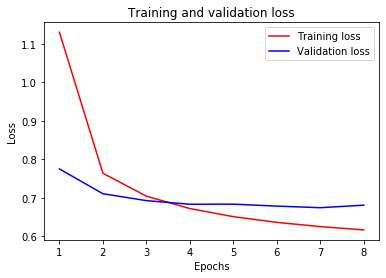

In [24]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Results Analysis

In [0]:
test = pd.DataFrame({
    'title':np.array(test_set_data),
    'real':real_categories,
    'predicted':predicted_categories
})
#test

In [26]:
pd.options.display.max_rows = 50
test.head(50)

,title,real,predicted
0,Apple Mac Mini I5 (mid 2011) 2.3 Ghz Impecable...,MINI_PCS,MINI_PCS
1,Carabina 22 Diana,AIRSOFT_GUNS,AIRSOFT_GUNS
2,Z Bieleta Delantera Izquierda Peugeot 504 Gr-g...,SWAY_BAR_LINKS,SWAY_BAR_LINKS
3,Saaqaans Bsr-01 Maquinilla De Afeitar De Corte...,COMBS,SHAVING_MACHINES
4,Vino Valmont Tinto Caja X6 X750cc,WINES,WINES
5,Mecedora De Madera Marca Michael Thonet,SOFAS,ANTIQUE_CHAIRS
6,"Tira De Led Lj64-o3381a P/panel Lty400hl-04, ...",TV_REPLACEMENT_BACKLIGHT_LED_STRIPS,TV_REPLACEMENT_BACKLIGHT_LED_STRIPS
7,Cadena Ek Japon 428-118l Zanella Sapucai 125 (...,MOTORCYCLE_TRANSMISSION_KITS,MOTORCYCLE_DISTRIBUTION_CHAINS
8,Boligrafo Faber Castell Trilux X 10 Unidades,PENS,PENS
9,Cerradura Para Puerta Corrediza Kallay 5002,DOOR_AND_WINDOW_LOCKS,DOOR_AND_WINDOW_LOCKS


In [0]:
test.to_csv(directory+"/test-results.csv", index=False)

In [0]:
with open(directory+"/inverse_cat_dict.pickle", "wb") as fo:
    pickle.dump(inverse_cat_dict, fo)

In [0]:
with open(directory+"/predictions.pickle", "wb") as fo:
    pickle.dump(predictions, fo)